In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('2020EDA').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [4]:
df_2020 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/2020", inferSchema=True, header=True)
# figure out how to read in shp file msca-bdp-student-gcs/bdp-rideshare-project/neighborhoods/shp files
df_weather = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/weather/chicago 2020-01-01 to 2022-08-31.csv", inferSchema=True, header=True)
df_2020.printSchema()
df_weather.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tip: integer (nullable = true)
 |-- Additional Charges: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Shared Trip Authorized: boolean (nullable = true)
 |-- Trips Pooled: integer (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid Longitude: double (nullable = true)
 |-- Dropof

In [5]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

df_2020.rdd.getNumPartitions()

97

In [6]:
displaypartitions(df_2020)

Partitions: 97


+-----------+------+
|partitionId| count|
+-----------+------+
|         96|258032|
|         26|500083|
|          5|501403|
|         25|501617|
|          9|501838|
|         13|501919|
|         30|501968|
|         17|502424|
|         42|502478|
|         21|502487|
|         34|502608|
|         38|505369|
|         29|505648|
|         24|505937|
|          8|506529|
|          4|507322|
|         39|507425|
|         32|507539|
|         10|508044|
|          1|508091|
|         35|508308|
|         20|508847|
|         28|508849|
|          7|508943|
|         33|509077|
|          0|509157|
|         12|509264|
|         14|509338|
|         22|509490|
|         16|509594|
|         37|509717|
|         19|509765|
|         27|509816|
|         41|510016|
|         18|510197|
|         23|510233|
|         15|510280|
|         11|510321|
|         40|510615|
|          2|511375|
|         36|511411|
|          6|511524|
|          3|511528|
|         31|513062|
|         43|

In [7]:
df_2020.describe().show()

+-------+--------------------+--------------------+--------------------+-----------------+-----------------+--------------------+--------------------+---------------------+----------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+
|summary|             Trip ID|Trip Start Timestamp|  Trip End Timestamp|     Trip Seconds|       Trip Miles| Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area|             Fare|               Tip|Additional Charges|        Trip Total|      Trips Pooled|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid Location|
+-------+--------------------+--------------------+--------------------+-----------------+-----------------+--

In [8]:
#Find the number of missing values for each column
from pyspark.sql.functions import isnan, when, count, col
df_2020.select([count(when(df_2020[c].isNull(), c)).alias(c) for c in df_2020.columns]).show()

+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+----+------------------+----------+----------------------+------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+
|Trip ID|Trip Start Timestamp|Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area|Fare| Tip|Additional Charges|Trip Total|Shared Trip Authorized|Trips Pooled|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid Location|
+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+----+------------------+----------+-------------------

<AxesSubplot:>

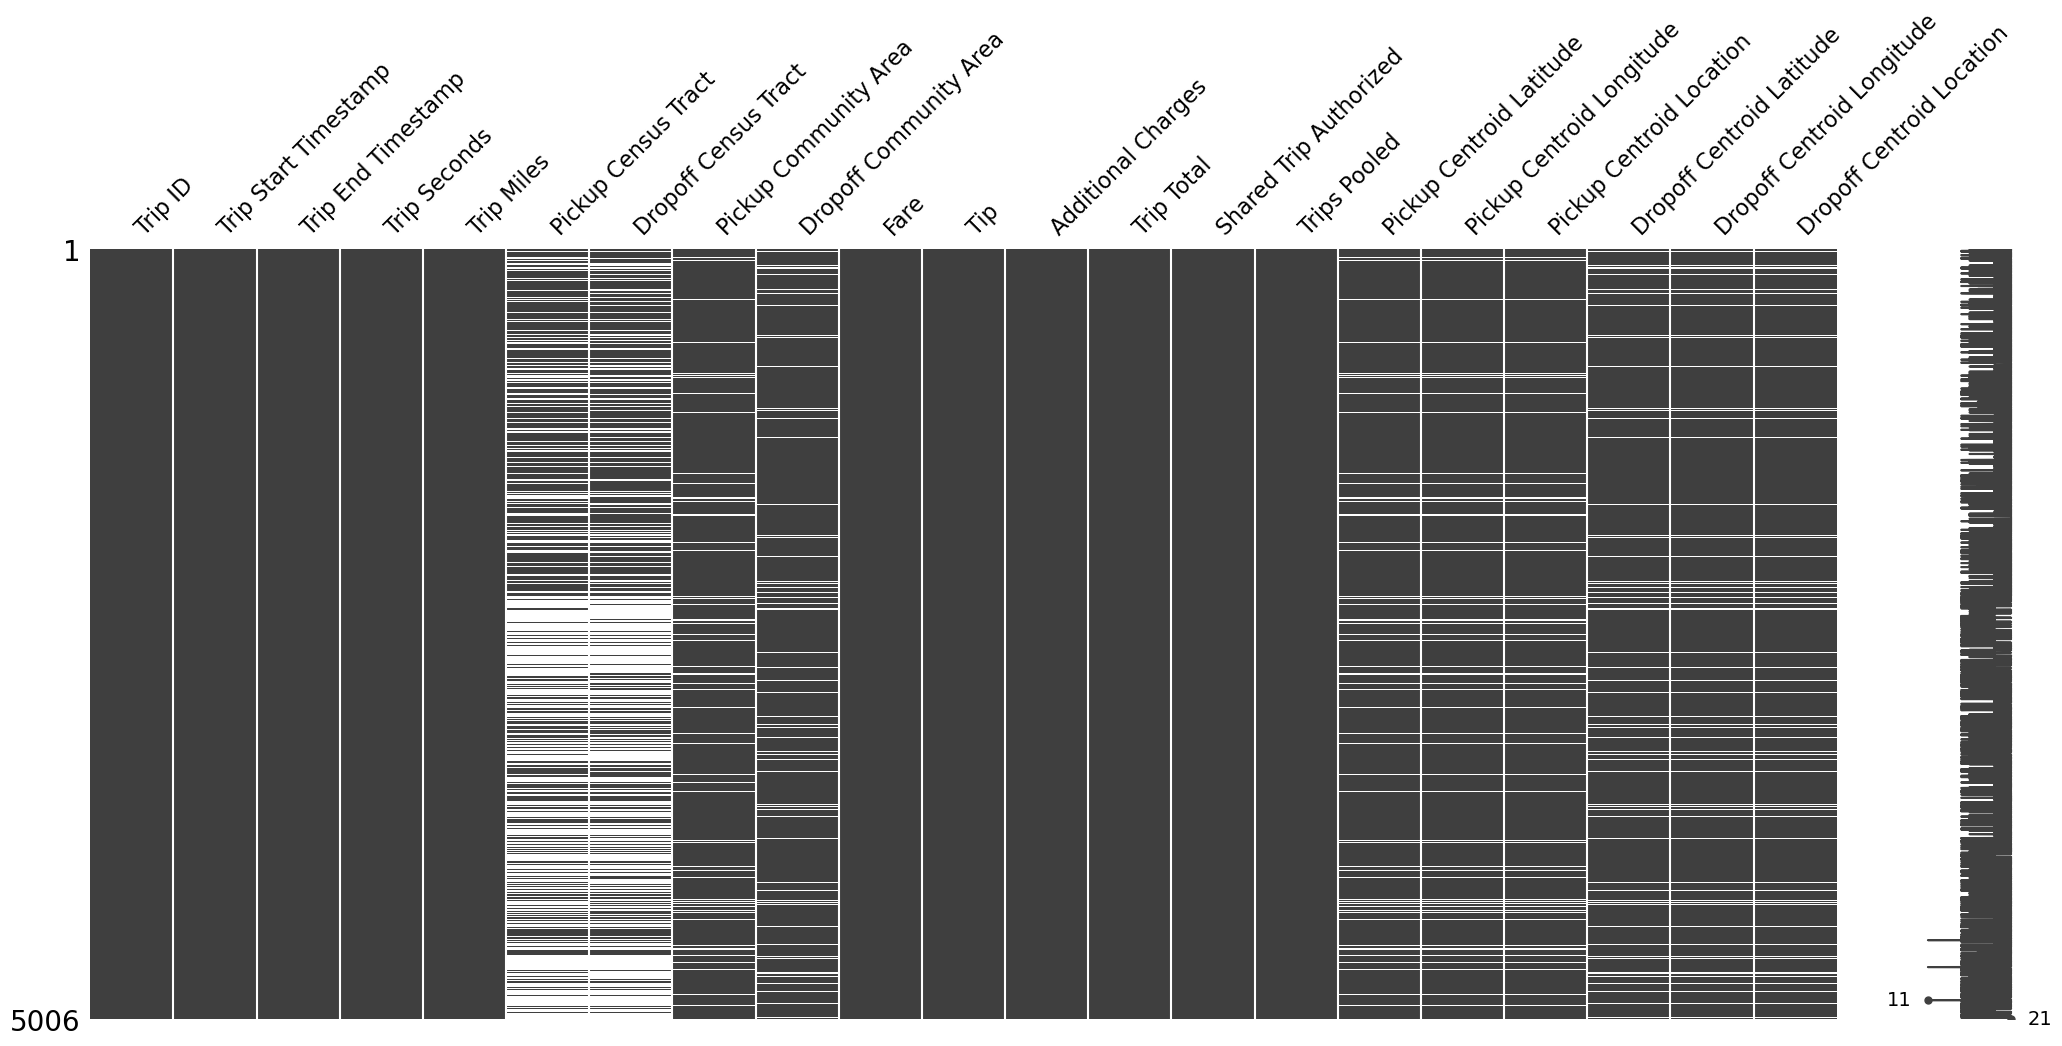

In [9]:
import missingno as msno
%matplotlib inline
msno.matrix(df_2020.sample(fraction=1/10000).toPandas())

In [10]:
#Approximate number of 2020 trips
from pyspark.sql.functions import approxCountDistinct

df_2020.select(approxCountDistinct("Trip ID", rsd = 0.01)).show()

23/11/16 01:59:12 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------------------+
|approx_count_distinct(Trip ID)|
+------------------------------+
|                      50256700|
+------------------------------+



In [11]:
# number of observations with all the data in each column
df_2020.dropna(how='any').count()

23700840

In [12]:
# Working with just data that contains full information and check for dupes
df_2020 = df_2020.dropna(how='any', subset=['Trip Start Timestamp','Trip End Timestamp','Fare','Dropoff Community Area','Pickup Community Area'])
df_2020 = df_2020.dropDuplicates()

In [13]:
# Drop columns unlikely to be useful for analysis for speed of computation and rename columns to remove spacing for ease of code writing
df_2020 = df_2020.drop('Trips Pooled','Additional Charges','Shared Trip Authorized','Pickup Centroid Location','Dropoff Centroid Location')
df_2020 = df_2020.withColumnRenamed("Trip ID","ID").withColumnRenamed("Trip Start Timestamp","start_timestamp").withColumnRenamed("Trip End Timestamp","end_timestamp").withColumnRenamed("Trip Miles",\
                "miles").withColumnRenamed("Pickup Census Tract","pickup_tract").withColumnRenamed("Dropoff Census Tract","dropoff_tract").withColumnRenamed("Pickup Community Area","pickup_area"\
                ).withColumnRenamed("Dropoff Community Area","dropoff_area").withColumnRenamed("Trip Total","total").withColumnRenamed("Pickup Centroid Latitude","pickup_lat").withColumnRenamed(\
                "Pickup Centroid Longitude","pickup_lon").withColumnRenamed("Pickup Centroid Location","pickup_location").withColumnRenamed("Dropoff Centroid Latitude","dropoff_lat").withColumnRenamed(\
                "Dropoff Centroid Longitude","dropoff_lon").withColumnRenamed("Dropoff Centroid Location","dropoff_location").withColumnRenamed("Trip Seconds","seconds")
# fix datatypes
df_2020 = df_2020.withColumn('start_timestamp', F.to_timestamp(df_2020['start_timestamp'], 'MM/dd/yyyy hh:mm:ss a')).withColumn('end_timestamp', F.to_timestamp(df_2020['end_timestamp'], 'MM/dd/yyyy hh:mm:ss a'))
df_weather = df_weather.withColumn('datetime',F.to_date(df_weather['datetime'], "yyyy-MM-dd"))

In [14]:
# add the time columns
df_2020 = df_2020.withColumn('month', F.month(df_2020.start_timestamp))
df_2020 = df_2020.withColumn('day_of_month', F.dayofmonth(df_2020.start_timestamp))
df_2020 = df_2020.withColumn('hour', F.hour(df_2020.start_timestamp))
df_2020 = df_2020.withColumn('day', F.dayofweek(df_2020.start_timestamp))
df_2020.show(3)

+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----+-------------+--------------+-------------+--------------+-----+------------+----+---+
|                  ID|    start_timestamp|      end_timestamp|seconds|miles|pickup_tract|dropoff_tract|pickup_area|dropoff_area|Fare|Tip|total|   pickup_lat|    pickup_lon|  dropoff_lat|   dropoff_lon|month|day_of_month|hour|day|
+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----+-------------+--------------+-------------+--------------+-----+------------+----+---+
|084b474ff41bde283...|2020-01-04 20:15:00|2020-01-04 20:30:00|    823|  5.1| 17031320100|  17031832300|         32|          22|10.0|  3|15.55|41.8849871918|-87.6209929134|41.9192250505| -87.671445766|    1|           4|  20|  7|
|0ebadbb0bf0b38c85...|2020-01-04 20:15:00|2020-01-04 20:45:00|   1589| 14.5| 170

In [15]:
sample_df = df_2020.sample(fraction=1/10000).toPandas().loc[:,["pickup_area","dropoff_area","total","Fare","Tip","total","miles","seconds","hour","day","month"]]

In [16]:
sample_df = sample_df.dropna()
sample_df = sample_df.drop_duplicates()

In [17]:
sample_df = sample_df.drop(columns='total')

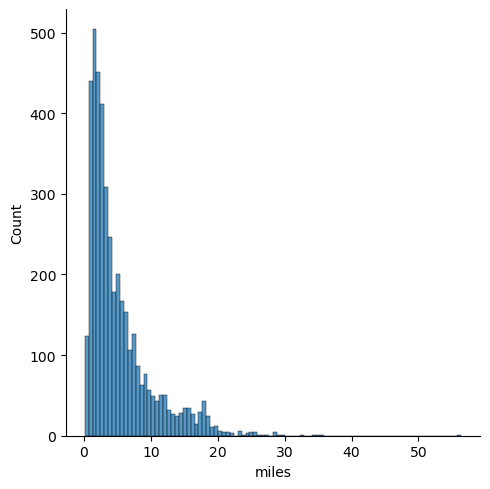

In [18]:
import seaborn as sns
sns.displot(sample_df, x="miles")

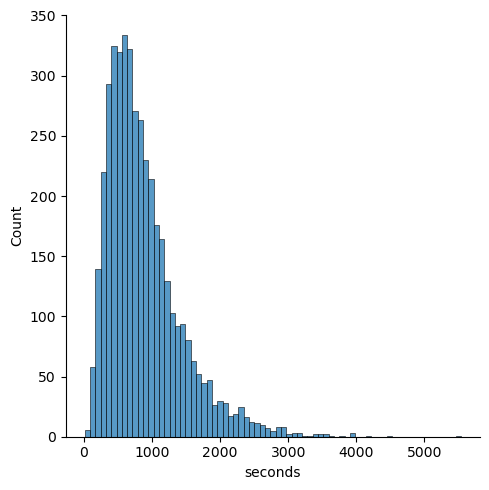

In [20]:
sns.displot(sample_df, x="seconds")

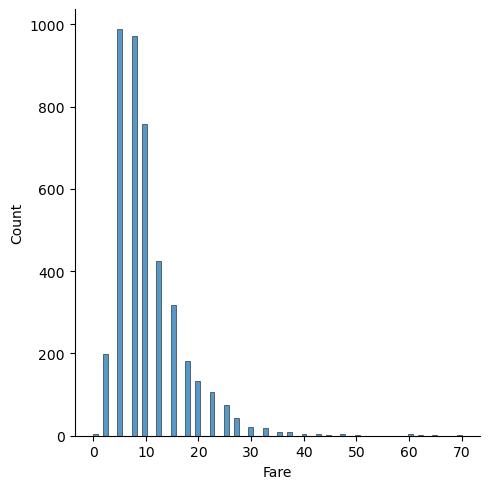

In [19]:
sns.displot(sample_df, x="Fare")

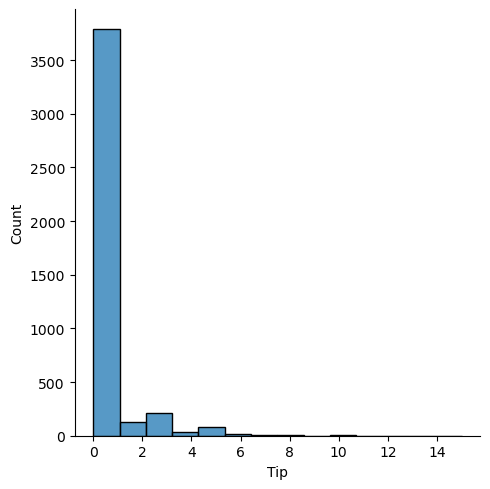

In [21]:
sns.displot(sample_df, x="Tip")

In [22]:
# get rides that occurred within hyde park
# add kenwood and woodlawn to this list - only if the other location is hyde park                    
df_hp = df_2020.filter((df_2020.pickup_area == 41) & (df_2020.dropoff_area == 41))
df_kw = df_2020.filter(((df_2020.pickup_area == 41) & (df_2020.dropoff_area == 42)) | ((df_2020.pickup_area == 42) & (df_2020.dropoff_area == 41)))
df_wl = df_2020.filter(((df_2020.pickup_area == 41) & (df_2020.dropoff_area == 39)) | ((df_2020.pickup_area == 39) & (df_2020.dropoff_area == 41)))
df_area = df_hp.union(df_kw).union(df_wl)

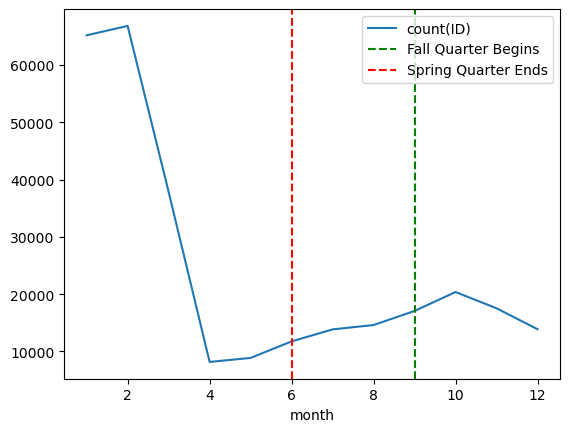

In [23]:
import matplotlib.pyplot as plt
df_count_plot = df_area.groupby("month").agg({'ID':'count'}).orderBy(F.col('month').asc()).toPandas() #.plot(x="month",y="count(ID)")
ax = df_count_plot.plot(x="month", y="count(ID)")
ax.axvline(x=9, color='g', linestyle='--', label='Fall Quarter Begins')
ax.axvline(x=6, color='r', linestyle='--', label='Spring Quarter Ends')
plt.legend()
plt.show()

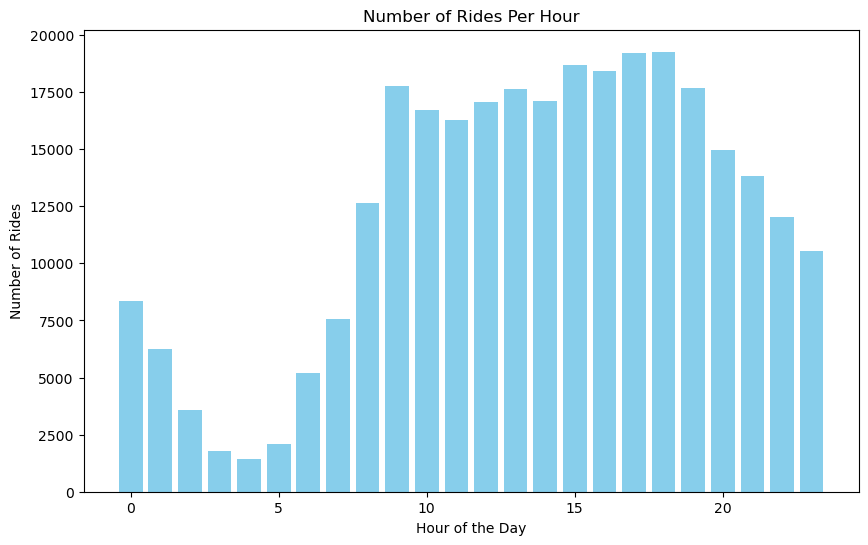

In [24]:
# rides per hour:
rides_per_hour = df_area.groupBy("hour").count().orderBy("hour")

# Convert the result to Pandas for local plotting
rides_per_hour_pd = rides_per_hour.toPandas()

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(rides_per_hour_pd["hour"], rides_per_hour_pd["count"], color="skyblue")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Rides")
plt.title("Number of Rides Per Hour")
plt.show()

<AxesSubplot:xlabel='month'>

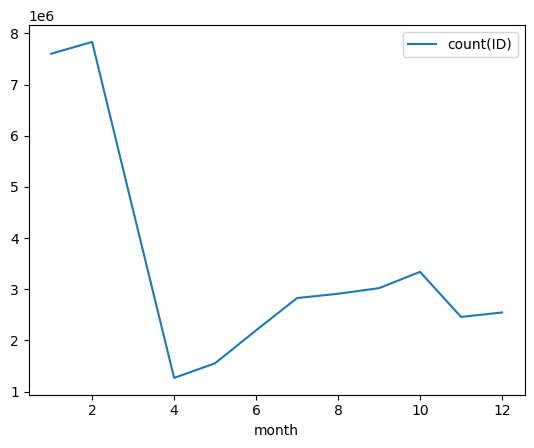

In [25]:
# basic plots for all rides (not just in the program area)
df_2020.groupby("month").agg({'ID':'count'}).orderBy(F.col('month').asc()).toPandas().plot(x="month",y="count(ID)")

In [26]:
df_total = df_2020.groupby("pickup_area").agg({'ID':'count'}).orderBy(F.col('pickup_area').asc()).toPandas()

<Figure size 1000x1000 with 0 Axes>

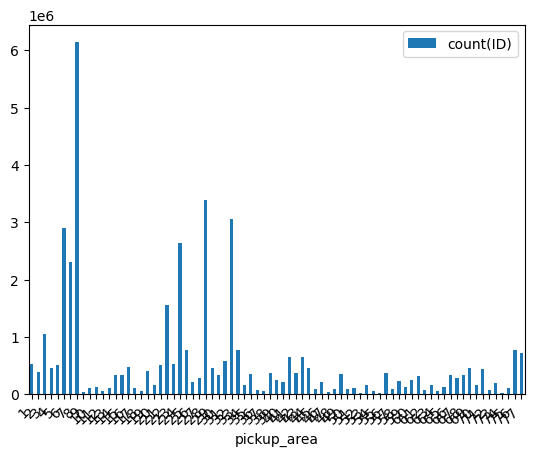

In [27]:
%matplotlib inline
plt.figure(figsize=(10, 10))
ax = df_total.plot(x="pickup_area",y="count(ID)", kind='bar')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

<AxesSubplot:xlabel='dropoff_area'>

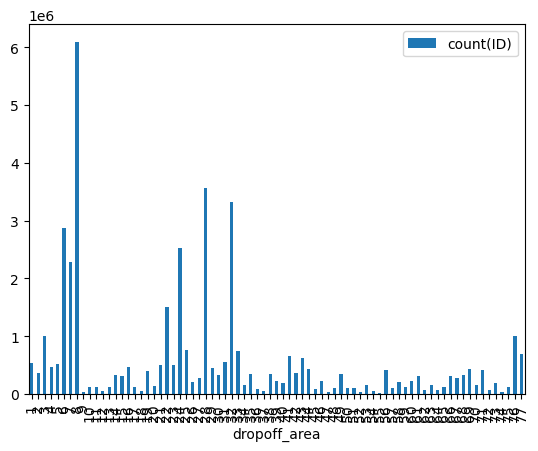

In [28]:
df_2020.groupby("dropoff_area").agg({'ID':'count'}).orderBy(F.col('dropoff_area').asc()).toPandas().plot(x="dropoff_area",y="count(ID)", kind='bar')

In [29]:
df_area.write.option("header", "true").csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_2020.csv")
df_2020.write.option("header", "true").csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/rides_2020.csv")